# Prática Independente: A maldição da dimensionalidade.

#### Para entender o efeito da quantidade de dimensões na capacidade preditiva do modelo, vamos trabalhar com um classificador de notícias de dois jornais argentinos para tentar distingui-los com base no vocabulário que eles usam. <br />

#### Para isso, vamos implementar um modelo de tipo `Naïve Bayes` com vetorização de tipo `TF-IDF`.

#### Exercício 1: Carregue o arquivo `clarin.csv` em um dataframe, definindo para ele um atributo de classe `class = 0`. Carregue também o arquivo 'pagina12.csv’ em um dataframe separado, também criando um atributo de classe `class = 1`. Faça a concatenação dos dois dataframes.

#### Realize uma análise exploratória, com uma limpeza dos dados, estudando a existência de dados nulos e fazendo a imputação de dados onde necessário, escolha o método que mais lhe convir.

#### Remova as seções em que os dois jornais usam um vocabulário semelhante e de domínio muito específico, como esportes, por exemplo.

#### Construa uma Corpus de documentos composto de uma coluna sobre a que iremos prever concatenando o título, resumo e corpo das diferentes notícias.

#### Realize a normalização dos dados, convertendo o corpus de notícias para minúsculas, removendo acentos que possam gerar diferenças artificiais entre as palavras, removendo também a pontuação, deixando apenas palavras.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

#Tamanho padrões das figuras e a fonte de seus textos neste notebook
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14

In [2]:
#Leitura dos dados
clarin= pd.read_csv('clarin.csv')
pagina12= pd.read_csv('pagina12.csv')

#Retirando coluna desnecessária
clarin.drop(columns= ['Unnamed: 0'], inplace= True)
pagina12.drop(columns= ['Unnamed: 0'], inplace= True)

In [3]:
#Criando coluna com as classes 0 e 1 para os respectivos dataframes
clarin= clarin.assign(target= 0)
pagina12= pagina12.assign(target= 1)

#Conferindo duas instâncias aleatórias dos dois dataframes na coluna target
print(clarin['target'].sample(2))
print(pagina12['target'].sample(2))

138    0
326    0
Name: target, dtype: int64
21     1
148    1
Name: target, dtype: int64


In [4]:
#Concatenando os dois dataframes
df= pd.concat([clarin, pagina12], ignore_index=True, axis= 0)
df.sample(3, random_state= 12)

,cuerpo,fecha_hora,imagen,resumen,suplemento,titulo,url,target
265,"El entrenador de la selección de Ecuador, Jo...",10/10/2017,//images.clarin.com/2017/10/10/rJiPDdcnb_930x5...,Jorge Célico fue suspendido por una discusión ...,/deportes/,Ecuador-Argentina: el entrenador local no podr...,http://www.clarin.com/deportes/seleccion-nacio...,0
440,"En La Tempestad, Shakespeare incluyó una figur...",09 de octubre de 2017,https://images.pagina12.com.ar/styles/focal_16...,NaN,Contratapa,Intelectuales siglo XXI,https://www.pagina12.com.ar/67931-intelectuale...,1
151,Si Argentina no llegara a ganarle a Ecuador ...,10/10/2017,//images.clarin.com/2017/10/05/SyO9jXV2b_930x5...,"Se enfrentan en San Pablo, desde las 20:30, te...",/deportes/futbol/,"Brasil-Chile por las Eliminatorias: horario, T...",http://www.clarin.com/deportes/futbol/brasil-c...,0


### 1. Limpeza

#### 1.1 Faltantes

A partir do dataset observamos que os campos que provavelmente contêm vocabulário relevante são "corpo", "título" e "resumo".
Remover da análise os registros que não possuem corpo ou título disponíveis e completar os resumos faltantes com um campo em branco


In [5]:
#Removendo colunas com vocabulários não relevantes
df.drop(columns= ['imagen', 'url'], inplace= True)

In [6]:
#Retirando valores nulos considerando colunas cuerpo e titulo
df.dropna(axis=0, subset=['cuerpo', 'titulo', 'suplemento'], inplace=True)

In [7]:
#Preenchendo valores nulos em resumen com uma string vazia
df['resumen'].fillna(value= '', inplace= True)

#### 1.2 Suplementos relevantes

Para melhorar a classificação, é conveniente retirar as seções em que os dois jornais usam um vocabulário semelhante e de domínio muito específico como, por exemplo, aqueles relacionados a esportes.

In [8]:
df['suplemento'].unique()

array(['/lo-ultimo/', '/politica/', '/mundo/', '/sociedad/',
       '/policiales/', '/ciudades/', '/opinion/', '/cartas_al_pais/',
       '/cultura/', '/rural/', '/economia/', '/tecnologia/',
       '/revista-enie/', '/viva/', '/br/', '/deportes/futbol/',
       '/deportes/ascenso/', '/deportes/futbol-internacional/',
       '/deportes/messi/', '/deportes/rugby/', '/deportes/tenis/',
       '/deportes/automovilismo/', '/deportes/basquet/',
       '/deportes/polideportivo/', '/deportes/turf/', '/deportes/boxeo/',
       '/deportes/hockey/', '/deportes/', '/espectaculos/fama/',
       '/espectaculos/tv/', '/espectaculos/cine/',
       '/espectaculos/musica/', '/espectaculos/teatro/', '/si/',
       '/espectaculos/', '/entremujeres/', '/autos/', '/buena-vida/',
       '/viajes/', '/arq/', 'El país', 'El mundo', 'Sociedad', 'Deportes',
       'Contratapa', 'Economía', 'Universidad', 'Plástica'], dtype=object)

In [9]:
supl_retirar= ['/deportes/futbol/', '/deportes/ascenso/', '/deportes/futbol-internacional/', 
          '/deportes/messi/', '/deportes/rugby/', '/deportes/tenis/', 
         '/deportes/automovilismo/', '/deportes/basquet/', 
          '/deportes/polideportivo/', '/deportes/turf/', '/deportes/boxeo/',
         '/deportes/hockey/', '/deportes/', 'Deportes']

In [10]:
#dataframe onde os valores da coluna suplemento estão nos valores que iremos retirar em supl_retirar
mascara = df['suplemento'].isin(supl_retirar)

#Mantendo os dados que não possuem o suplemento relacionado a esportes
df= df[~mascara]

#Conferindo quais valores em suplemento permaneceram
df['suplemento'].unique()

array(['/lo-ultimo/', '/politica/', '/mundo/', '/sociedad/',
       '/policiales/', '/ciudades/', '/opinion/', '/cartas_al_pais/',
       '/cultura/', '/rural/', '/economia/', '/tecnologia/',
       '/revista-enie/', '/viva/', '/br/', '/espectaculos/fama/',
       '/espectaculos/tv/', '/espectaculos/cine/',
       '/espectaculos/musica/', '/espectaculos/teatro/', '/si/',
       '/espectaculos/', '/entremujeres/', '/autos/', '/buena-vida/',
       '/viajes/', '/arq/', 'El país', 'El mundo', 'Sociedad',
       'Contratapa', 'Economía', 'Universidad', 'Plástica'], dtype=object)

#### 1.3 Corpus

Construa a coluna sobre a que iremos prever concatenando o título, resumo e corpo das diferentes notícias.

In [11]:
#Criando coluna corpus com o título, o resumo e o corpo da notícia
df= df.assign(corpus= df['titulo'] + ' ' + df['resumen'] + df['cuerpo'])

#Conferindo concatenação feita utilizando primeira instância dos dados
exemplo=  df['titulo'].values[0] + ' ' + df['resumen'].values[0] + df['cuerpo'].values[0]
corpus_exemplo= df['corpus'].values[0]
print(exemplo[:396])
print()
print(corpus_exemplo[:396])

Soja: aumentó la superficie sembrada con semilla fiscalizada De acuerdo a los datos relevados por el Instituto Nacional de Semillas (INASE), el área declarada creció 4,25% y alcanzó el 36,3 % del área sembrada en todo el país.  El Ministerio de Agroindustria de la Nación, a través del Instituto Nacional de Semilla (INASE), publicó un informe acerca de la identificación de usuarios, variedades,

Soja: aumentó la superficie sembrada con semilla fiscalizada De acuerdo a los datos relevados por el Instituto Nacional de Semillas (INASE), el área declarada creció 4,25% y alcanzó el 36,3 % del área sembrada en todo el país.  El Ministerio de Agroindustria de la Nación, a través del Instituto Nacional de Semilla (INASE), publicó un informe acerca de la identificación de usuarios, variedades,


#### 1.4 Normalização do texto

Primeiro, é conveniente passar todo o corpus a letras minúsculas.

Para melhorar o classificador, é importante retirar todos os acentos que possam gerar diferenças artificiais entre as palavras, caso estejam colocados ou não. Hint: Usar o módulo unidecode

Uma vez retirados os acentos, remover todos os sinais de pontuação para deixar somente palavras. Dica: usar uma expressão regular, por exemplo, r'([^\s\w]|_)+' para substituir tudo que não for palavra.

In [12]:
#Convertendo para minúsculas
df['corpus']= df['corpus'].apply(lambda x: x.lower())

In [13]:
#Removendo acentos
def remove_acentos(x):
    '''Função que remove os acentos do corpus'''
    x= unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

df['corpus']= df['corpus'].apply(lambda x: remove_acentos(x))

In [14]:
#Removendo pontuações
df['corpus']= df['corpus'].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))

In [15]:
#Removendo números
df['corpus']= df['corpus'].apply(lambda x: ''.join([p for p in x if not p.isdigit()]))

#### Exercício 2: Vetorize o corpus resultante com a técnica `TF-IDF` e aplique um modelo `Naive Bayes` com um `split` simples entre os subconjuntos de treino e teste. 

#### Discuta qual é a dimensão da matriz de atributos e a precisão obtida. Plote também uma matriz de confusão.

In [16]:
#Instanciando objeto tfidf
tfidf=  TfidfVectorizer().fit(df['corpus'])

In [17]:
#Variáveis/palavras preditoras
x_tfidf= tfidf.transform(df['corpus'])

#Passando preditoras para dataframe
X= pd.DataFrame(x_tfidf.toarray(), columns= tfidf.get_feature_names())

#Variável resposta
y= df['target']

X.sample(2)

,aa,aadet,aaes,aal,aaron,abaixo,abajo,abajocalificacion,abajodivertido,abajotitulado,...,zoologico,zorra,zorro,zuain,zubizarreta,zucchini,zucchinis,zurdo,zurich,zvyagintsev
115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print(f'Colunas: {X.shape[1]}')

Colunas: 27910


In [19]:
#Separação conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, random_state=42)

In [20]:
#Instanciando modelo Gaussian Naive Bayes
gnb = GaussianNB()

In [21]:
#Ajuste do modelo aos dados de treino e previsões
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [22]:
#Acurácia do modelo
acc= accuracy_score(y_test, y_pred).round(3) * 100
print(f'Acurácia: {acc}%')

Acurácia: 76.3%


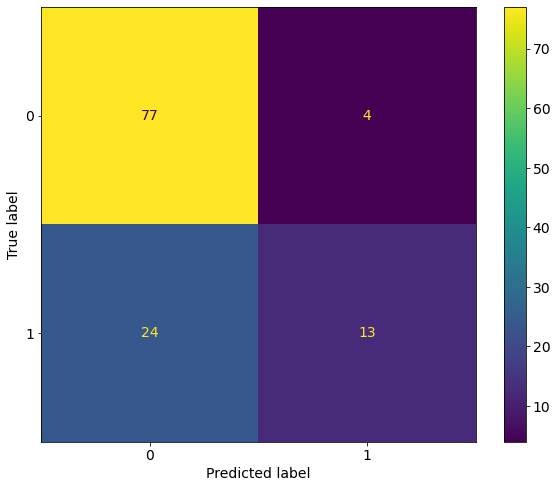

In [23]:
#Matriz de confusão
plot_confusion_matrix(gnb, X_test, y_test); 

In [24]:
#Conferindo balanceamento das classes
df['target'].value_counts()

0    258
1    134
Name: target, dtype: int64

O modelo não teve uma acurácia (76%) e predições tão ruins quanto era de se esperar pela baixa quantidade de dados e o alto valor de colunas pra previsão. Nesse sentido, com uma limpeza ainda melhor dos dados, podemos imaginar um modelo ainda melhor em performance.

#### Exercício 3: Realize a redução da dimensionalidade do modelo apresentado.

#### Considerando a relação entre o número de atributos e o número de casos de treinamento, discuta se, de acordo com a maldição da dimensionalidade, esta relação é um problema.

#### Faça uso da lista de `stopwords `, com palavras do idioma espanhol que não têm um peso semântico significativo para a redução da dimensionalidade. Treinem novamente o modelo, removendo as `stopwords` contidas no arquivo "stopwords.csv".

#### Discuta o que acontece com o número de dimensões da matriz de atributos e o que acontece com sua precisão.

#### Exercício 4: Seguindo adiante na redução de dimensões, e considerando que modelo melhora quando removemos as `stopwords`, mas que ainda temos um número alto de dimensões, dada a quantidade de dados que temos. Considere:

#### Para remover da análise as palavras que aparecem menos do que determinado número de vezes, a classe `TfidfVectorizer` tem um parâmetro `min_df`, que criar o vocabulário, ignora termos que tenham uma frequência de documento estritamente menor que o limite especificado.

#### Definir o parâmetro `min_df = 6` e volte a executar o modelo. Discuta quanto se reduz a dimensão da matriz de atributos e quanto o desempenho do algoritmo é melhorado com a adoção desse procedimento.